In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from collections import namedtuple
from typing_extensions import NamedTuple
import sympy
import math
import random

np.random.seed(10)
random.seed(100)

Design a tree based classification algorithm that takes a list of $[(x,y)]$ values and designs a decision tree with less than or greater than equal to   splits that approximates the data generation process.

Here $x \in \mathbb{R}^d, y \in \mathbb{R}/ \mathbb{N}$

In [ ]:
class Node:

    def __init__(self, data, dimension = 0, initialized = False, median = 0, error = 0,
                 upper_bound = None, lower_bound = None, var = None, split_range = 20):

        self.data = data
        self.dimension = dimension
        self.error = 0
        if data != []:
            self.state_dimension = len(self.data[0].x)
            self.split_range = split_range

            if not initialized:
                self.upper_bound = np.max([p.x[dimension] for p in data])
                self.lower_bound = np.min([p.x[dimension] for p in data])
                self.var = (self.upper_bound - self.lower_bound + 1) / len(data)
                self.median = np.median([p.x[dimension] for p in data])
                self.split_val = self.median
                self.action = np.median([p.y for p in data])
                for p in data:
                    error += np.abs(p.y - self.action)
                self.error = error

    def is_null_node(self):
        return len(self.data) == 0

    def calculate_split(self):

        best_dimension = 0
        best_error = np.inf
        total_error = self.error
        best_split_val = 0
        best_left_node = None
        best_right_node = None

        if (len(self.data) != 0):
            for dim in range(self.state_dimension):
                lower_bound = np.min([p.x[dim] for p in self.data])
                upper_bound = np.max([p.x[dim] for p in self.data])
                var = (upper_bound - lower_bound + 1) / len(self.data)
                split_list = np.linspace(lower_bound, upper_bound, self.split_range)

                for split_val in split_list:

                    left_data = []
                    right_data = []

                    for datapoint in self.data:
                        if (datapoint.x[dim] < split_val):
                            left_data.append(datapoint)
                        else:
                            right_data.append(datapoint)

                    if left_data != [] and right_data != []:
                        left_node = Node(left_data)
                        right_node = Node(right_data)
                        total_error = left_node.error + right_node.error

                        if total_error < best_error:
                            self.dimension = dim
                            self.split_val = split_val
                            best_error = total_error
                            best_split_val = split_val
                            best_left_node = left_node
                            best_right_node = right_node

            if best_left_node == None:
                print('Left node is empty')
                return Node([]), self

            elif best_right_node == None:
                print('Right node is empty')
                return self, Node([])

        return best_left_node, best_right_node


    def info(self):

        print('Node information is given as following:')
        print(f'{len(self.data)} is the number of data points analyzed in this dataset')
        print(f'{self.dimension} is the selected dimension for the node')
        print(f'{self.state_dimension} is the dimension of the state space')
        print(f'{self.upper_bound} is the upper bound')
        print(f'{self.lower_bound} is the lower bound')
        print(f'{self.var} is the variance')
        print(f'{self.median} if the median')

    def __str__(self):

        return f'{len(self.data)}: Number of points, all points in the {self.dimension} dimension'

In [ ]:
class Tree:

    def __init__(self, head, max_depth, curr_depth=1):
        self.head = head
        self.curr_depth = curr_depth
        self.max_depth = max_depth
        if head.data != []:
            self.left = Tree(Node([]), max_depth, self.curr_depth+1)
            self.right = Tree(Node([]), max_depth, self.curr_depth+1)

    def build_tree(self):

        if self.curr_depth < self.max_depth:

            left_node, right_node = self.head.calculate_split()

            if (left_node == None) or (right_node == None):
                print(f'Tree pruned at {self.curr_depth}')
                self.max_depth = self.curr_depth
                return

            self.left = Tree(left_node, self.max_depth, self.curr_depth + 1)
            self.right = Tree(right_node, self.max_depth, self.curr_depth + 1)

            self.left.build_tree()
            self.right.build_tree()

        else:
            self.left = Tree(Node([]), self.max_depth, curr_depth = self.max_depth+1)
            self.right = Tree(Node([]), self.max_depth, curr_depth = self.max_depth+1)


    def print_tree(self):

        if len(self.head.data) != 0:
            print(f'{self.head.dimension}th dimension < {self.head.split_val}, depth {self.curr_depth}, action {self.head.action}')
            if self.curr_depth < self.max_depth:
                self.left.print_tree()
                self.right.print_tree()

    def plot_splits(self, ax, action_color_dict,
                    color_bounds = [-0.05, 5], plotted_colors=[]):

        if (len(self.head.data) == 0):
            print(f'Empty node found at {self.head.curr_depth}')

        else:
            print(f'Plot line $x={self.head.split_val}$')
            ax.axvline(x=self.head.split_val,
                       color=(0, 0, 0),
                       linestyle='-')


        print(plotted_colors)

        # We color the regions in the second to last depth where we partition the
        # space

        if self.curr_depth == self.max_depth - 1:

            if self.left.head.action not in plotted_colors:
                ax.axvspan(color_bounds[0], self.head.split_val, alpha = 0.8,
                        color = action_color_dict[self.left.head.action],
                        label= f'Action = {self.left.head.action}')
                plotted_colors.append(self.left.head.action)
            else:
                ax.axvspan(color_bounds[0], self.head.split_val, alpha = 0.8,
                           color = action_color_dict[self.left.head.action])

            if self.right.head.action not in plotted_colors:
                ax.axvspan(self.head.split_val, color_bounds[1], alpha=0.8,
                            color = action_color_dict[self.right.head.action],
                            label = f'Action = {self.right.head.action}')
                plotted_colors.append(self.right.head.action)
            else:
                ax.axvspan(self.head.split_val, color_bounds[1], alpha=0.8,
                            color = action_color_dict[self.right.head.action])

            plt.legend()
            ax.set_title('Splits of the space')

        if self.curr_depth < self.max_depth:
            (self.left).plot_splits(ax, action_color_dict,
                [color_bounds[0], self.head.split_val])

            (self.right).plot_splits(ax, action_color_dict,
                [self.head.split_val, color_bounds[1]])


    def plot_tree(self, x, y, step_x, step_y, bounds = [-3, 3]):

        # Plot current node
        if self.curr_depth <= self.max_depth:
            plt.text(x, y, f"{round(bounds[0],2)} < $x_{self.head.dimension}$ < {round(bounds[1],2)}\nAction={self.head.action}",
                    ha='center', va='center', bbox=dict(facecolor='lightblue', alpha=0.5, edgecolor='black'),
                    fontsize=10, fontweight='bold', style='italic', fontfamily='serif')

            plt.plot([x, x-step_x], [y, y-step_y], 'b-', linewidth=1)  # Arrow towards left child
            plt.plot([x, x+step_x], [y, y-step_y], 'b-', linewidth=1)  # Arrow towards right child

            # Plot left child
            self.left.plot_tree(x - step_x, y - step_y, step_x/2, step_y, [bounds[0], self.head.split_val])

            # Plot right child
            self.right.plot_tree(x + step_x, y - step_y, step_x/2, step_y, [self.head.split_val, bounds[1]])

    def calculate_approximation_error(self, total = 0):

        if self.curr_depth == self.max_depth:
            return self.head.error
        else:
            total += self.left.calculate_approximation_error(total)
            total += self.right.calculate_approximation_error(total)

        return total

To Do:

*   Error VS Depth of Tree
*   Work on tree plot
*   Add this to the MDP setup
*   Work on 2D/ND versions of this

In [ ]:
Data = namedtuple('data', ['x', 'y'])
point = Data(np.random.randn(5), 1)
print(point.x, point.y)

[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597] 1


In [ ]:
def generate_data(size, dimension, f):

    data = []
    for i in range(size):
        x = np.random.randn(dimension)
        y = f(x)
        datapoint = Data(x,y)
        data.append(datapoint)
    return data

def f(x, lam = 1.0):
    return np.exp(lam * np.sum(x)) / (1 + np.exp(lam * np.sum(x)))

def g(x):
    return math.floor(x) % 3

In [ ]:
SIZE = 100
DIMENSIONS = 1
DEPTH = 3
DEPTH_RANGE = np.arange(3,10,2)
depth_to_error = {}

data = generate_data(SIZE, DIMENSIONS, g)
n = Node(data, 0)
t = Tree(n, DEPTH)
t.build_tree()

<ipython-input-262-f1ad6f883fdc>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.floor(x) % 3


In [ ]:
t.print_tree()

0th dimension < 0.046933601215546794, depth 1, action 1.0
0th dimension < -1.007499719315479, depth 2, action 2.0
0th dimension < -1.7997788882550276, depth 3, action 1.0
0th dimension < -0.34500606875165296, depth 3, action 2.0
0th dimension < 0.9657162497956007, depth 2, action 0.0
0th dimension < 0.319356421091224, depth 3, action 0.0
0th dimension < 1.3084730808634777, depth 3, action 1.0


Plot line $x=0.046933601215546794$
[]
Plot line $x=-1.007499719315479$
[]
Plot line $x=-1.7997788882550276$
[1.0, 2.0]
Plot line $x=-0.34500606875165296$
[1.0, 2.0]
Plot line $x=0.9657162497956007$
[1.0, 2.0]
Plot line $x=0.319356421091224$
[1.0, 2.0, 0.0]
Plot line $x=1.3084730808634777$
[1.0, 2.0, 0.0]


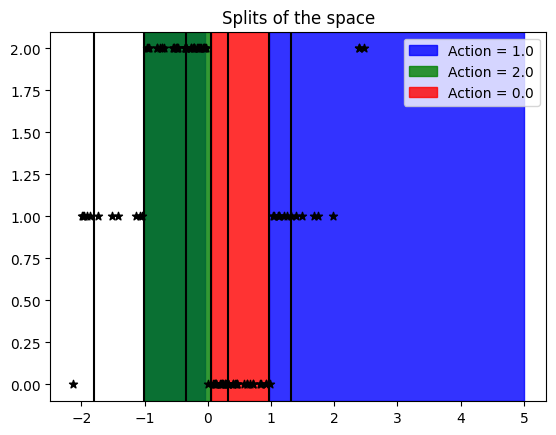

In [ ]:
x_vals = [p.x for p in data]
y_vals = [p.y for p in data]
action_color_dict = {0:'red', 1:'blue', 2:'green'}

fig, ax = plt.subplots()
t.plot_splits(ax, action_color_dict)
ax.scatter(x_vals, y_vals, marker = '*',color='black')

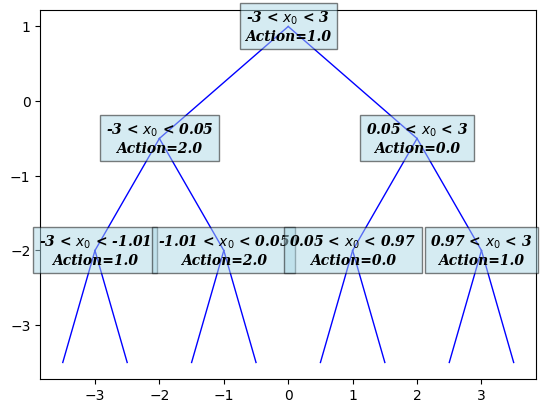

In [ ]:
t.plot_tree(0, 1, 2, 1.5)

<ipython-input-262-f1ad6f883fdc>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.floor(x) % 3


Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Left node is empty
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Tree pruned at 7
Left node is empty
Tree pruned at 8
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Tree pruned at 7
Left node is empty
Tree pruned at 8
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Tree pruned at 7
Left node is empty
Tree pruned at 8
Left node is empty
Left nod

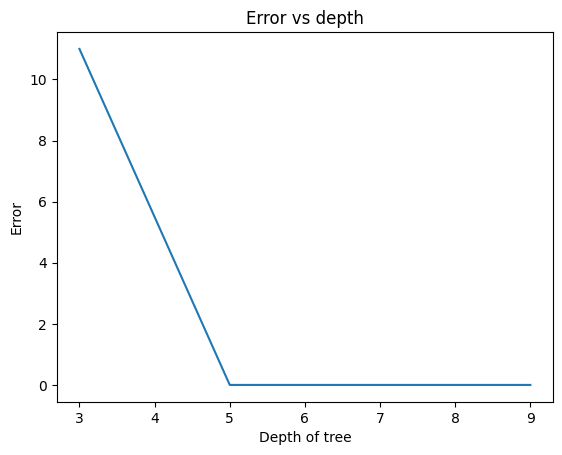

In [ ]:
SIZE = 100
DIMENSIONS = 1
DEPTH = 3
DEPTH_RANGE = np.arange(3,10,2)
depth_to_error = {}

data = generate_data(SIZE, DIMENSIONS, g)
n = Node(data, 0)

for d in range(3,10,2):
    t = Tree(n,d)
    t.build_tree()
    depth_to_error[d] = t.calculate_approximation_error()

plt.plot(DEPTH_RANGE, [depth_to_error[d] for d in DEPTH_RANGE])
plt.title('Error vs depth')
plt.xlabel('Depth of tree')
plt.ylabel('Error')
plt.show()

In [ ]:
import numpy as np

class BloodGlucoseEnvironment:
    def __init__(self, num_states=30, actions=[0, 1, 2], discount_factor=0.8):
        self.num_states = num_states
        self.actions = actions
        self.discount_factor = discount_factor
        self.T = self._compute_transition_probabilities()
        self.R = self._compute_rewards()

    def _compute_transition_probabilities(self):
        T = np.zeros((self.num_states, len(self.actions), self.num_states))
        for s in range(self.num_states):
            for a in self.actions:
                if a == 0:
                    for t in range(min(s + 10, self.num_states)):
                        T[s, a, t] = 0.7 / min(s + 10, self.num_states)
                    for t in range(s + 1):
                        T[s, a, t] += 0.3 / (s + 1)
                elif a == 1:
                    for t in range(min(s + 5, self.num_states)):
                        T[s, a, t] = 0.3 / min(s + 5, self.num_states)
                    for t in range(s + 1):
                        T[s, a, t] += 0.7 / (s + 1)
                elif a == 2:
                    for t in range(s + 1):
                        T[s, a, t] = 1.0 / (s + 1)
        return T

    def _compute_rewards(self):
        R = np.zeros((self.num_states, len(self.actions), self.num_states))
        for s in range(self.num_states):
            for a in self.actions:
                for t in range(self.num_states):
                    R[s, a, t] = 1.5 / (abs((s / 29) - (a / 2)) + 1) + np.abs(s/29 - a/2)/20
        return R

    def step(self, state, action):
        next_state = np.random.choice(self.num_states, p=self.T[state, action])
        reward = self.R[state, action, next_state]
        return next_state, reward

    def get_transition_probabilities(self):
        return self.T

    def get_rewards(self):
        return self.R


In [ ]:
def policy_iteration(env, num_iterations=1000):
    policy = np.zeros(env.num_states, dtype=int)  # Initialize policy arbitrarily
    V = np.zeros(env.num_states)  # Initialize value function
    gamma = env.discount_factor

    for _ in range(num_iterations):
        # Policy evaluation
        for s in range(env.num_states):
            action = policy[s]
            next_state, reward = env.step(s, action)
            V[s] = reward + gamma * V[next_state]

        # Policy improvement
        new_policy = np.zeros(env.num_states, dtype=int)
        for s in range(env.num_states):
            best_action = None
            best_value = float('-inf')
            for a in env.actions:
                next_state, reward = env.step(s, a)
                value = reward + gamma * V[next_state]
                if value > best_value:
                    best_value = value
                    best_action = a
            new_policy[s] = best_action
        if np.array_equal(new_policy, policy):
            break
        policy = new_policy

    return policy, V

# Create the environment
env = BloodGlucoseEnvironment()

# Find the optimal policy
optimal_policy, optimal_values = policy_iteration(env)

print("Optimal Policy:")
print(optimal_policy)
print("Optimal Values:")
print(optimal_values)


Optimal Policy:
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
Optimal Values:
[6.61008886 6.77906779 6.82992831 6.51470784 6.55341689 6.75197511
 6.71714462 6.59709586 6.3396292  6.55842341 6.64011494 6.55626229
 6.82967014 6.64058199 6.9228681  6.72217707 6.67154923 6.72917863
 6.76775025 6.55127592 6.73429498 6.48156884 6.48238854 6.64063795
 6.53477118 6.61314946 6.58740354 6.78038978 6.76418973 6.78807109]


In [ ]:
def make_list_into_function(l):

    def functor(num):

        if (num >= len(l)) or (num < 0):
            return 0
        else:
            return l[num]

    return functor


optimal_function = make_list_into_function(optimal_policy)

In [ ]:
data =  [Data(np.array([i]), y) for i,y in enumerate(optimal_policy)]
n = Node(data, 0)
t = Tree(n, DEPTH)
t.build_tree()
print(t.print_tree())

0th dimension < 7.631578947368421, depth 1, action 1.0
0th dimension < 0.3684210526315789, depth 2, action 0.0
0th dimension < 0.0, depth 3, action 0.0
0th dimension < 4.0, depth 3, action 0.0
0th dimension < 22.368421052631582, depth 2, action 1.0
0th dimension < 15.0, depth 3, action 1.0
0th dimension < 26.0, depth 3, action 2.0
None


Plot line $x=7.631578947368421$
[]
Plot line $x=0.3684210526315789$
[1.0, 2.0, 0.0]
Plot line $x=0.0$
[1.0, 2.0, 0.0]
Plot line $x=4.0$
[1.0, 2.0, 0.0]
Plot line $x=22.368421052631582$
[1.0, 2.0, 0.0]
Plot line $x=15.0$
[1.0, 2.0, 0.0]
Plot line $x=26.0$
[1.0, 2.0, 0.0]


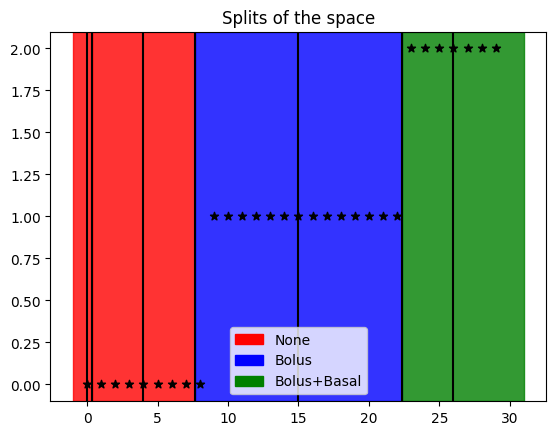

In [ ]:
x_vals = [p.x for p in data]
y_vals = [p.y for p in data]
action_color_dict = {0:'red', 1:'blue', 2:'green'}

fig, ax = plt.subplots()
t.plot_splits(ax, action_color_dict, color_bounds=[-1,31], plotted_colors = [])
ax.scatter(x_vals, y_vals, marker = '*',color='black')

red_patch = mpatches.Patch(color='red', label='None')
blue_patch = mpatches.Patch(color='blue', label='Bolus')
green_patch = mpatches.Patch(color='green', label='Bolus+Basal')

ax.legend(handles=[red_patch, blue_patch, green_patch])

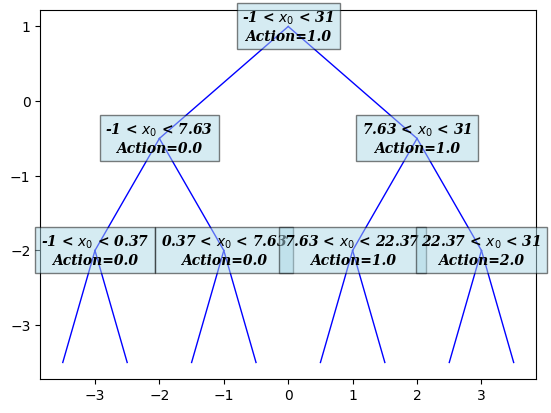

In [ ]:
t.plot_tree(0, 1, 2, 1.5, bounds = [-1,31])

Left node is empty
Left node is empty
Tree pruned at 4
Left node is empty
Left node is empty
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 4
Left node is empty
Tree pruned at 5
Left node is empty
Left node is empty
Tree pruned at 5
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 5
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 5
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 4
Left node is empty
Tree pruned at 5
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Tree pruned at 5
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 5
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Tree pruned at 6
Left node is empty
Left node is empty
Left node is empty
Tree pruned at 5
Left node is empty
Tree pruned at 6
Left node is empty
Left nod

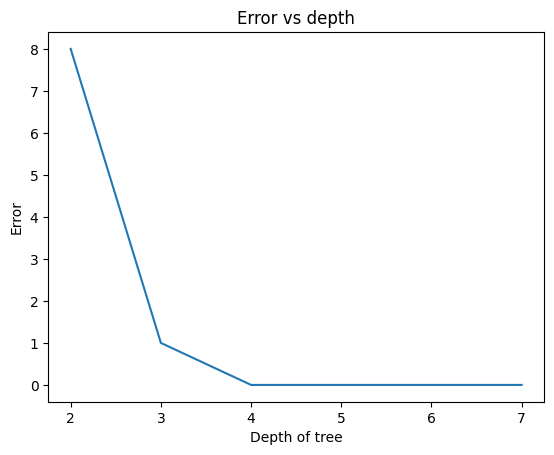

In [ ]:
n = Node(data, 0)

for d in range(2,8):
    t = Tree(n,d)
    t.build_tree()
    depth_to_error[d] = t.calculate_approximation_error()

plt.plot(range(2,8), [depth_to_error[d] for d in range(2,8)])
plt.title('Error vs depth')
plt.xlabel('Depth of tree')
plt.ylabel('Error')
plt.show()